SwinTransformerSys expand initial----depths:[2, 2, 2, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.0;num_classes:2
---final upsample expand_first---
[ 0.43 mins] After 1 epochs, the Average training loss is  tensor(0.6158) and average DICE score is tensor(0.6059) and average cc loss is tensor(0.5650, grad_fn=<DivBackward0>)
[ 0.11 mins] After 1 epochs, the Average validations loss is  tensor(0.4776) and average DICE score is tensor(0.6172)
[ 0.53 mins] After 2 epochs, the Average training loss is  tensor(0.6131) and average DICE score is tensor(0.6063) and average cc loss is tensor(0.5623, grad_fn=<DivBackward0>)
[ 0.13 mins] After 2 epochs, the Average validations loss is  tensor(0.4650) and average DICE score is tensor(0.6176)


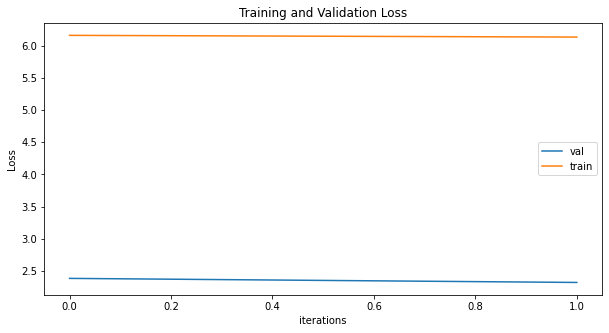

In [2]:
import voxelmorph2d as vm2d
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
import os
from skimage.transform import resize
import multiprocessing as mp
from tqdm import tqdm
import gc
import time
from sklearn.model_selection import train_test_split
from matplotlib.lines import Line2D
use_gpu = torch.cuda.is_available()


class VoxelMorph():
    """
    VoxelMorph Class is a higher level interface for both 2D and 3D
    Voxelmorph classes. It makes training easier and is scalable.
    """
    
    def __init__(self, input_dims, use_gpu=False):
        updated_lr = 0.001
        self.dims = input_dims
        self.vm = vm2d
        self.voxelmorph = vm2d.VoxelMorph2d(input_dims[0] * 2, use_gpu)
        self.optimizer = optim.Adam(self.voxelmorph.parameters(), lr=updated_lr, weight_decay=0, amsgrad=True)
        self.criterion = nn.MSELoss()
        #self.optimizer = optim.SGD(
        #    self.voxelmorph.parameters(), lr=1e-4, momentum=0.99)
        self.params = {'batch_size': 3,
                       'shuffle': True,
                       'num_workers': 6,
                       'worker_init_fn': np.random.seed(42)
                       }
        self.device = torch.device("cuda:0" if use_gpu else "cpu")

    def check_dims(self, x):
        try:
            if x.shape[1:] == self.dims:
                return
            else:
                raise TypeError
        except TypeError as e:
            print("Invalid Dimension Error. The supposed dimension is ",
                  self.dims, "But the dimension of the input is ", x.shape[1:])

    def forward(self, x):
        self.check_dims(x)
        return voxelmorph(x)

    def calculate_loss(self, y, ytrue, n=7, lamda=10, is_training=True):
        loss = self.criterion(y,ytrue) + self.vm.vox_morph_loss(y, ytrue, n, lamda)
        #loss = self.vm.vox_morph_loss(y, ytrue, n, lamda)
        return loss, self.vm.vox_morph_loss(y, ytrue, n, lamda)

    def train_model(self, batch_moving, batch_fixed, lr = 0.001, n=7, lamda=10, return_metric_score=True):
        updated_lr = round(lr * np.power(1 - (0) / 5,0.9),8)
        self.optimizer.zero_grad()
        batch_fixed, batch_moving = batch_fixed.to(
            self.device), batch_moving.to(self.device)
        registered_image = self.voxelmorph(batch_moving, batch_fixed)
        train_loss, cc_sm_loss = self.calculate_loss(
            registered_image, batch_fixed, n, lamda)
        train_loss.backward()
        self.optimizer.step()
        if return_metric_score:
            train_dice_score = self.vm.dice_score(
                registered_image, batch_fixed)
            return train_loss, train_dice_score, updated_lr, cc_sm_loss
        return train_loss, updated_lr

    def get_test_loss(self, batch_moving, batch_fixed, n=7, lamda=10):
        with torch.set_grad_enabled(False):
            registered_image = self.voxelmorph(batch_moving, batch_fixed)
            val_loss = self.vm.vox_morph_loss(
                registered_image, batch_fixed, n, lamda)
            val_dice_score = self.vm.dice_score(registered_image, batch_fixed)
            return val_loss, val_dice_score


class Dataset(data.Dataset):
    """
    Dataset class for converting the data into batches.
    The data.Dataset class is a pyTorch class which help
    in speeding up  this process with effective parallelization
    """
    'Characterizes a dataset for PyTorch'

    def __init__(self, list_IDs):
        'Initialization'
        self.list_IDs = list_IDs

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        fixed_image = torch.Tensor(
            resize(io.imread('NIH/test_xrays/' + 'a_' + ID), (224, 224, 3)))
        moving_image = torch.Tensor(
            resize(io.imread('NIH/test_xrays/' + 'b_' + ID), (224, 224, 3)))
        return fixed_image, moving_image


def main():
    vm = VoxelMorph(
        (3, 224, 224))  # Object of the higher level class
    DATA_PATH = 'NIH/xrays/'
    params = {'batch_size': 3,
              'shuffle': True,
              'num_workers': 6,
              'worker_init_fn': np.random.seed(42)
              }

    max_epochs = 2
    filename = list(set([x.split('_')[1] + '_' + x.split('_')[2]
                         for x in os.listdir('NIH/test_xrays/')]))
    partition = {}
    partition['train'], partition['validation'] = train_test_split(
        filename, test_size=0.33, random_state=42)
    
    # Generators
    training_set = Dataset(partition['train'])
    training_generator = data.DataLoader(training_set, **params)

    validation_set = Dataset(partition['validation'])
    validation_generator = data.DataLoader(validation_set, **params)
    
    updated_lr = 0.001
    
    train_losses = []
    val_losses=[]
    
    # Loop over epochs
    for epoch in range(max_epochs):
        start_time = time.time()
        train_loss = 0
        train_dice_score = 0
        val_loss = 0
        val_dice_score = 0
        cc_sm_loss = 0
        
                
        for batch_fixed, batch_moving in training_generator:
            loss, dice, updated_lr, cc_sm = vm.train_model(batch_moving, batch_fixed, updated_lr)
            train_dice_score += dice.data
            train_loss += loss.data
            cc_sm_loss += cc_sm
        print('[', "{0:.2f}".format((time.time() - start_time) / 60), 'mins]', 'After', epoch + 1, 'epochs, the Average training loss is ', train_loss *
              params['batch_size'] / len(training_set), 'and average DICE score is', train_dice_score.data * params['batch_size'] / len(training_set), 
              'and average cc loss is', cc_sm_loss * params['batch_size'] / len(training_set))

        train_losses.append(train_loss)

                           
        
        # Testing time
        start_time = time.time()
        for batch_fixed, batch_moving in validation_generator:
            # Transfer to GPU
            loss, dice = vm.get_test_loss(batch_moving, batch_fixed)
            val_dice_score += dice.data
            val_loss += loss.data
                    
        val_losses.append(val_loss)
        
        
        print('[', "{0:.2f}".format((time.time() - start_time) / 60), 'mins]', 'After', epoch + 1, 'epochs, the Average validations loss is ', val_loss *
              params['batch_size'] / len(validation_set), 'and average DICE score is', val_dice_score.data * params['batch_size'] / len(validation_set))
    

        
        

    plt.figure(figsize=(10,5))
    plt.title("Training and Validation Loss")
    plt.plot(val_losses,label="val")
    plt.plot(train_losses,label="train")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
                       
        
        
main()